In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
reward_map = [1, 0, 2, 0.5]
reward_map = np.array(reward_map)

In [3]:
def list_to_str(in_list):
    out = ""
    for tmp_v in in_list:
        out = out + str(tmp_v)
    return out

In [4]:
'''
Creating a matrix \overline{M}(s, a', s')
'''
def create_q_func_mat(_M, n_state=16, n_action=4):
    tmp_M = np.copy(_M)
    for i in range(n_state):
        for j in range(n_action):
            tmp_M[i*n_action+j, i] = 0.0
    return tmp_M

def create_initial_mat(_M, n_state=16, n_action=4):
    tmp_M = np.copy(_M)
    for i in range(n_state):
        for j in range(n_action):
            tmp_M[i*n_action+j, i] = 1.0
    return tmp_M

In [5]:
def compute_intrisic_rewards(q_M, n_state=16, n_action=4):
    out_vec = np.zeros(n_state)
    for i in range(n_state):
        tmp_v = 0.0
        for j in range(n_action):
            tmp_v = tmp_v + np.sum(q_M[n_action*i + j])
        out_vec[i] = tmp_v
    return out_vec

In [6]:
def create_q_values(M, n_state=16, n_action=4):
    q_M = create_q_func_mat(M, n_state=n_state, n_action=n_action)
    int_rwds = compute_intrisic_rewards(q_M, n_state=n_state, n_action=n_action)
    q_vals = []
    for i in range(n_state*n_action):
        q_vals.append(np.dot(q_M[i,:], int_rwds))
    q_vals = np.array(q_vals).reshape(n_state, n_action)
    return q_vals

In [7]:
def compute_mean_action_sr(M, obs_id, n_state=4**5, n_action=2):
    out_vec = np.zeros(n_state)
    for i in range(n_action):
        out_vec = out_vec + M[obs_id*n_action+i, :]
    out_vec = out_vec / float(n_action)
    return out_vec

In [8]:
def softmax(a, beta=1.0):
    c = np.max(a)
    exp_a = np.exp(a*beta)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

# N = 2

## SR Empowerment vs Q model

In [9]:
game_history = []
error_history = []
q_error_history = []
memory = []

num_memory = 2
n_games = 1000000

lr = 0.1
gamma = 0.8
q_gamma = 0.95

beta = 1.0

n_state=4**num_memory
n_action=2

M = np.zeros((n_state*n_action, n_state))
M = create_initial_mat(M, n_state=n_state, n_action=n_action)

a2_Qs = np.zeros((n_state, n_action))

In [10]:
s1_mat = []
s2_mat = []
cur_obs = None
next_obs = None
for i in range(n_games):
    ## action of agent2 (Tit for Tat)
    if i%100000 == 0:
        print("episode", i)
    if i == 0:
        a2_action = 0 ## c
    else:
        a2_action = memory[-1][0]
    ## action of agent1
    if len(memory) < num_memory:
        a1_action = np.random.randint(0, 2)
        a2_action = np.random.randint(0, 2)
        memory.append([a1_action, a2_action])
    else:
        cur_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        q_vals = create_q_values(M, n_state=4**num_memory, n_action=2)
        a1_action = np.random.choice([0, 1], p=softmax(q_vals[cur_obs,:], beta=beta))
        a2_action = np.random.choice([0, 1], p=softmax(a2_Qs[cur_obs,:], beta=beta))
        s1_mat.append(np.mean(q_vals, axis=1).reshape(1, -1))
        s2_mat.append(np.mean(a2_Qs, axis=1).reshape(1, -1))
        _tmp = memory.pop(0)
        memory.append([a1_action, a2_action])
        ## SR
        current_act_idx = 2*cur_obs+a1_action
        next_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        next_sr_vec = compute_mean_action_sr(M, next_obs, n_state=n_state, n_action=2)
        td_err = np.eye(n_state)[cur_obs] + gamma*next_sr_vec - M[current_act_idx, :]
        error_history.append(np.mean(td_err))
        M[current_act_idx, :] = M[current_act_idx, :] + lr*td_err
        ## Q
        q_td_err = reward_map[a1_action+(2*a2_action)] + q_gamma*np.max(a2_Qs[next_obs]) - a2_Qs[cur_obs, a2_action]
        q_error_history.append(q_td_err)
        a2_Qs[cur_obs, a2_action] = a2_Qs[cur_obs, a2_action] + lr*q_td_err
    game_history.append(a1_action+(2*a2_action))

episode 0
episode 100000
episode 200000
episode 300000
episode 400000
episode 500000
episode 600000
episode 700000
episode 800000
episode 900000


<Figure size 432x288 with 0 Axes>

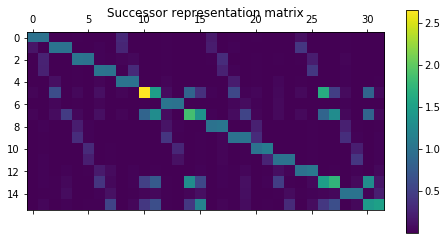

In [11]:
plt.figure()
plt.matshow(M.T)
plt.colorbar()
plt.title("Successor representation matrix")
plt.show()

In [12]:
q_arr = create_q_values(M, n_state=n_state, n_action=n_action)
s_vals = np.mean(q_arr, axis=1)
for i in range(len(q_arr)):
    print(format(i,'b').zfill(4), softmax(q_arr[i], beta=beta), s_vals[i])

0000 [0.32563768 0.67436232] 1.0151702337248143
0001 [0.66799687 0.33200313] 3.4139645138850945
0010 [0.68171264 0.31828736] 1.3079327786820087
0011 [0.73630346 0.26369654] 3.4122893360863067
0100 [0.53165723 0.46834277] 1.2068903729226186
0101 [0.01182779 0.98817221] 11.063513211570715
0110 [0.83302118 0.16697882] 1.4358471676472604
0111 [0.96227421 0.03772579] 11.394887030694605
1000 [0.33972766 0.66027234] 1.162076133482627
1001 [0.37618099 0.62381901] 4.0463348413443745
1010 [0.72409894 0.27590106] 1.1017231609238598
1011 [0.89624431 0.10375569] 2.6497795806288202
1100 [0.40331921 0.59668079] 1.8649316037269563
1101 [0.91850341 0.08149659] 12.596350607232043
1110 [0.58688677 0.41311323] 1.8275016737451875
1111 [9.99998633e-01 1.36667961e-06] 8.939826005460143


In [13]:
for i in range(len(a2_Qs)):
    print(format(i,'b').zfill(4), softmax(a2_Qs[i], beta=beta), np.mean(a2_Qs[i]))

0000 [0.31557781 0.68442219] 0.6531190101134572
0001 [0.09042684 0.90957316] 1.2732171674047317
0010 [0.2991103 0.7008897] 1.1007732999207922
0011 [0.12499307 0.87500693] 1.6530027057852337
0100 [0.31155052 0.68844948] 1.0545974612780757
0101 [9.14757919e-13 1.00000000e+00] 15.005360672484644
0110 [0.17013596 0.82986404] 1.338216770534503
0111 [5.46084733e-13 1.00000000e+00] 15.740549991274156
1000 [0.37843103 0.62156897] 0.8334702999285569
1001 [0.08283736 0.91716264] 1.8037821757747787
1010 [0.28959577 0.71040423] 0.9840467087794367
1011 [0.1588768 0.8411232] 1.1555397631599083
1100 [0.174832 0.825168] 1.232833858715147
1101 [4.60737994e-13 1.00000000e+00] 15.183388614452744
1110 [0.22955564 0.77044436] 1.4607378919917993
1111 [3.90337138e-13 1.00000000e+00] 15.675715899853218


<Figure size 720x720 with 0 Axes>

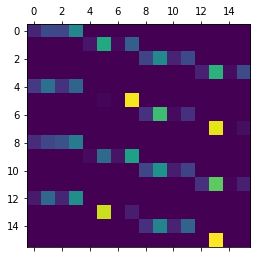

In [34]:
tran_mat = []
for i in range(len(q_arr)):
    tran_vec = np.zeros((1, len(q_arr)))
    prev_state = format(i,'b').zfill(4)[2:]
    for j in [0, 1]:
        for k in [0, 1]:
            next_state = int(prev_state + str(j) + str(k), 2)
            tran_vec[0, next_state] = softmax(a2_Qs[i], beta=beta)[k] * softmax(q_arr[i], beta=beta)[j]
    tran_mat.append(tran_vec)
tran_mat = np.concatenate(tran_mat)

plt.figure(figsize=(10, 10))
plt.matshow(tran_mat)

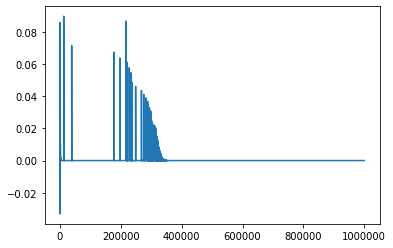

In [14]:
plt.plot(range(len(error_history)), error_history)

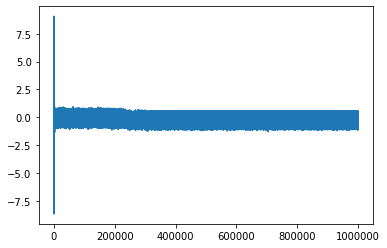

In [15]:
plt.plot(range(len(q_error_history)), q_error_history)

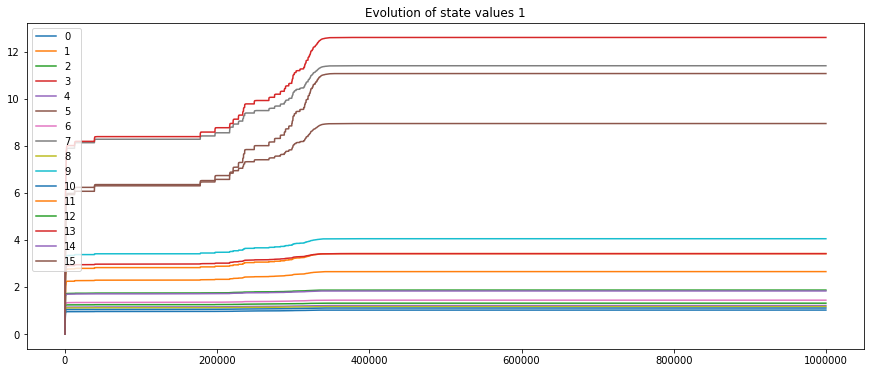

In [16]:
s1_mat = np.concatenate(s1_mat)
plt.figure(figsize=(15, 6))
for i in range(n_state):
    plt.plot(range(len(s1_mat)), s1_mat[:, i], label=str(i))
plt.title("Evolution of state values 1")
plt.legend()
plt.show()

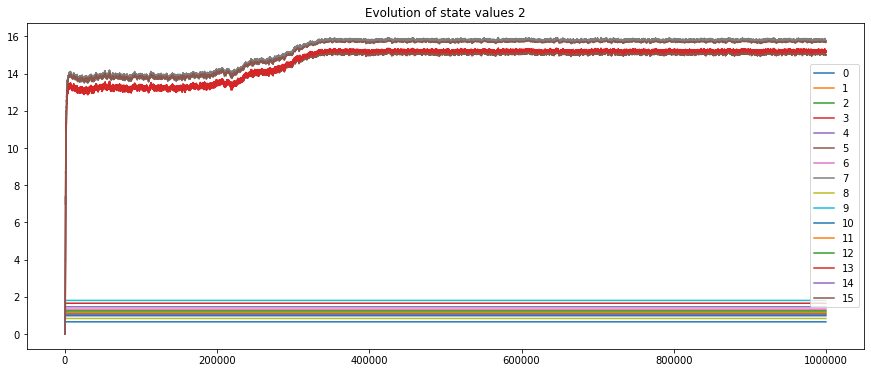

In [17]:
s2_mat = np.concatenate(s2_mat)
plt.figure(figsize=(15, 6))
for i in range(n_state):
    plt.plot(range(len(s2_mat)), s2_mat[:, i], label=str(i))
plt.title("Evolution of state values 2")
plt.legend()
plt.show()

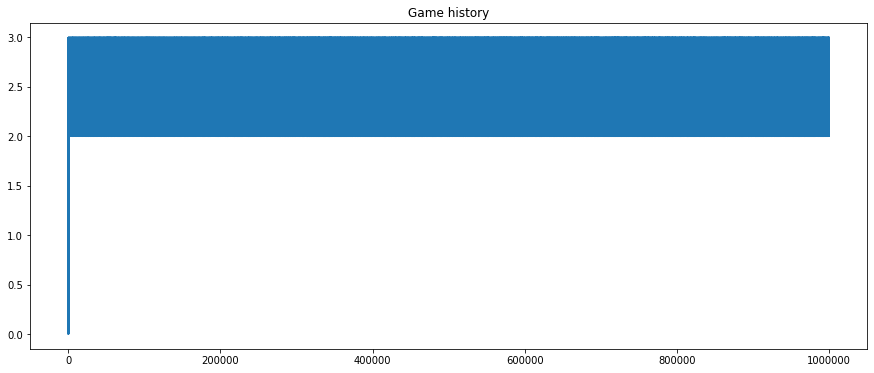

In [18]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(game_history)), game_history)
plt.title("Game history")
plt.show()

In [20]:
game_history[-10:]

[3, 2, 2, 3, 2, 2, 3, 2, 2, 3]

# N = 3

## SR Empowerment vs Q model

In [35]:
game_history = []
error_history = []
q_error_history = []
memory = []

num_memory = 3
n_games = 1000000

lr = 0.1
gamma = 0.8
q_gamma = 0.95

beta = 1.0

n_state=4**num_memory
n_action=2

M = np.zeros((n_state*n_action, n_state))
M = create_initial_mat(M, n_state=n_state, n_action=n_action)

a2_Qs = np.zeros((n_state, n_action))

In [36]:
s1_mat = []
s2_mat = []
cur_obs = None
next_obs = None
for i in range(n_games):
    ## action of agent2 (Tit for Tat)
    if i%100000 == 0:
        print("episode", i)
    if i == 0:
        a2_action = 0 ## c
    else:
        a2_action = memory[-1][0]
    ## action of agent1
    if len(memory) < num_memory:
        a1_action = np.random.randint(0, 2)
        a2_action = np.random.randint(0, 2)
        memory.append([a1_action, a2_action])
    else:
        cur_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        q_vals = create_q_values(M, n_state=4**num_memory, n_action=2)
        a1_action = np.random.choice([0, 1], p=softmax(q_vals[cur_obs,:], beta=beta))
        a2_action = np.random.choice([0, 1], p=softmax(a2_Qs[cur_obs,:], beta=beta))
        s1_mat.append(np.mean(q_vals, axis=1).reshape(1, -1))
        s2_mat.append(np.mean(a2_Qs, axis=1).reshape(1, -1))
        _tmp = memory.pop(0)
        memory.append([a1_action, a2_action])
        ## SR
        current_act_idx = 2*cur_obs+a1_action
        next_obs = int(list_to_str(np.array(memory).reshape(-1).tolist()), 2)
        next_sr_vec = compute_mean_action_sr(M, next_obs, n_state=n_state, n_action=2)
        td_err = np.eye(n_state)[cur_obs] + gamma*next_sr_vec - M[current_act_idx, :]
        error_history.append(np.mean(td_err))
        M[current_act_idx, :] = M[current_act_idx, :] + lr*td_err
        ## Q
        q_td_err = reward_map[a1_action+(2*a2_action)] + q_gamma*np.max(a2_Qs[next_obs]) - a2_Qs[cur_obs, a2_action]
        q_error_history.append(q_td_err)
        a2_Qs[cur_obs, a2_action] = a2_Qs[cur_obs, a2_action] + lr*q_td_err
    game_history.append(a1_action+(2*a2_action))

episode 0
episode 100000
episode 200000
episode 300000
episode 400000
episode 500000
episode 600000
episode 700000
episode 800000
episode 900000


<Figure size 432x288 with 0 Axes>

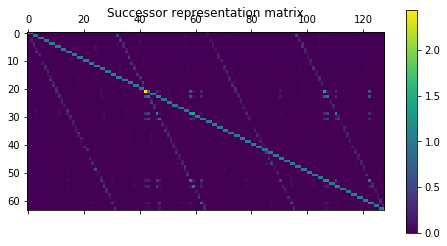

In [37]:
plt.figure()
plt.matshow(M.T)
plt.colorbar()
plt.title("Successor representation matrix")
plt.show()

In [45]:
q_arr = create_q_values(M, n_state=n_state, n_action=n_action)
s_vals = np.mean(q_arr, axis=1)
for i in range(len(q_arr)):
    print(format(i,'b').zfill(6), softmax(q_arr[i], beta=beta), s_vals[i])

000000 [0.41822339 0.58177661] 0.1728120804033843
000001 [0.49796356 0.50203644] 1.0022972725025854
000010 [0.53857482 0.46142518] 0.21471335108150003
000011 [0.62529448 0.37470552] 0.8013416991666985
000100 [0.585587 0.414413] 0.9001923760978924
000101 [0.49106732 0.50893268] 2.449980600534776
000110 [0.62519151 0.37480849] 0.4308346914619567
000111 [0.85470374 0.14529626] 1.6215471237139414
001000 [0.4370636 0.5629364] 0.35851281907264576
001001 [0.68650174 0.31349826] 0.6452467196798274
001010 [0.51800404 0.48199596] 0.23538161642245767
001011 [0.41375135 0.58624865] 0.6554331655391321
001100 [0.7408274 0.2591726] 0.6986537669852296
001101 [0.66370626 0.33629374] 2.973532015609727
001110 [0.54107161 0.45892839] 0.38804481503450267
001111 [0.76562033 0.23437967] 1.1504099623434372
010000 [0.53112683 0.46887317] 0.8771907788890418
010001 [0.60593132 0.39406868] 1.1211180791063249
010010 [0.59875304 0.40124696] 0.5855143511586978
010011 [0.73133361 0.26866639] 1.0169860813821339
010100

In [46]:
for i in range(len(a2_Qs)):
    print(format(i,'b').zfill(6), softmax(a2_Qs[i], beta=beta), np.mean(a2_Qs[i]))

000000 [0.49373656 0.50626344] 0.22723829666461456
000001 [0.40514444 0.59485556] 0.9057799001889811
000010 [0.57652993 0.42347007] 0.28795512739439244
000011 [0.40089866 0.59910134] 0.9795611149481173
000100 [0.31051637 0.68948363] 1.1547620607542393
000101 [0.02575915 0.97424085] 2.510924344581763
000110 [0.38242373 0.61757627] 0.7627259214511585
000111 [0.30871933 0.69128067] 1.248397928459132
001000 [0.40774456 0.59225544] 0.5323336107271511
001001 [0.52919321 0.47080679] 0.8178487779075359
001010 [0.32142206 0.67857794] 0.42301663355603447
001011 [0.25076601 0.74923399] 0.5910463756616136
001100 [0.14596337 0.85403663] 1.1801432094699884
001101 [0.08923603 0.91076397] 1.5841107293939622
001110 [0.37885239 0.62114761] 0.7146288174776174
001111 [0.20652806 0.79347194] 0.6729909500533019
010000 [0.16657962 0.83342038] 0.9208563289360748
010001 [0.32257389 0.67742611] 1.122382938867528
010010 [0.24314034 0.75685966] 0.9299619690413545
010011 [0.23955821 0.76044179] 1.143860667430383
0

<Figure size 720x720 with 0 Axes>

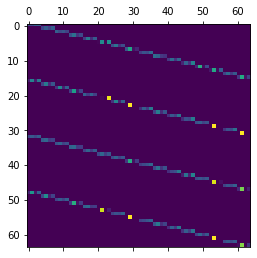

In [43]:
tran_mat = []
for i in range(len(q_arr)):
    tran_vec = np.zeros((1, len(q_arr)))
    prev_state = format(i,'b').zfill(6)[2:]
    for j in [0, 1]:
        for k in [0, 1]:
            next_state = int(prev_state + str(j) + str(k), 2)
            tran_vec[0, next_state] = softmax(a2_Qs[i], beta=beta)[k] * softmax(q_arr[i], beta=beta)[j]
    tran_mat.append(tran_vec)
tran_mat = np.concatenate(tran_mat)

plt.figure(figsize=(10, 10))
plt.matshow(tran_mat)

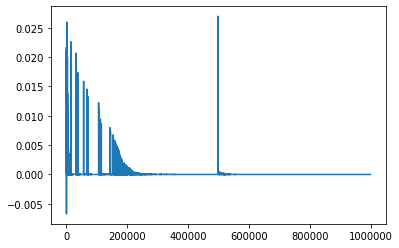

In [41]:
plt.plot(range(len(error_history)), error_history)

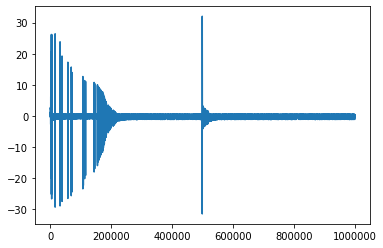

In [42]:
plt.plot(range(len(q_error_history)), q_error_history)

In [47]:
game_history[-1000:]

[3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
